# Imports

In [1]:
## Setting up API key and environment related imports

import os
import re
import sys
import openai
import getpass
import random
from dotenv import load_dotenv,find_dotenv
_ = load_dotenv(find_dotenv())

In [2]:
import uuid
from PIL import Image
from IPython.display import display,HTML, Image as IPythonImage

In [3]:
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
## LangGraph related imports

from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated
import operator

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [7]:
import functools
from typing import TypedDict, Annotated

In [8]:
## LangChain related imports

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage,ToolMessage, AIMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema import HumanMessage
from langchain_core.tools import tool
from langchain_experimental.agents import create_pandas_dataframe_agent

In [21]:
## Model/LLM related imports
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o",api_key = openai.api_key,temperature=0)

-----
<h1 style="text-align: center;">Multi- Agent Workflow</h1>

<p style="text-align: center;">
  <img src="SupervisorAgenticFlow_VII.png" />
</p>


## Defining various components

### >> <span style="background-color: yellow; color: black;">Supervisor</span>:

```
Supervisor is responsible for managing the conversation flow between multiple agents, ensuring that 
each agent performs their assigned tasks in the correct order based on the user's query. The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly. If no further action is needed, the Supervisor routes the process to FINISH. The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents like the BI Agent, Driver Identification Agent, Cost Saving Agent, and Generate Scenario Agent. 
```

----

#### >>> <span style="background-color: cyan; color: black;">Insights Agent</span>:
- **Role:**
```
Insights Agent is responsible for analyzing shipment data to generate insights. 
It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, 
identifying trends, comparing metrics across different dimensions (e.g., users, regions), and generating 
visualizations to help understand shipment-related patterns and performance.
```

- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**
    
----

#### >>> <span style="background-color: cyan; color: black;">Dynamic Cost Optimization Agent</span>:
- **Role:**
```
Dynamic Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and comparisons between current and optimized operations. The agent also calculates key performance metrics like cost per pallet, truck utilization rate, and cost savings over time. This agent is called when the user asks about shipment cost reduction or optimization scenarios.
```
- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**

----

#### >>> <span style="background-color: cyan; color: black;">Static Cost Optimization Agent</span>:
- **Role:**
```
The Static Cost Optimization Agent is designed to analyze and optimize shipment costs by evaluating (number of days of delivery) scenarios before and after consolidation. Using a Rate Card (which includes product type, short postcode, and cost per pallet), the agent calculates the base shipment costs. To maximize cost savings, the agent evaluates multiple delivery day scenarios (e.g., 5-day, 4-day, or 3-day delivery options).By applying consolidation day mappings, the agent aggregates shipments into fewer deliveries, reducing overall costs. The results include: Total shipment costs before and after consolidation, Percentage savings achieved ,Key metrics such as the number of shipments and average pallets per shipment. This tool empowers users to identify the most cost-effective delivery strategies while maintaining operational efficiency.
```
- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**

----

#### >>> <span style="background-color: cyan; color: black;">Generate Scenario Agent</span>:
- **Role:**
```
Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios 
based on user-defined parameters. This agent helps compare the outcomes of various decisions 
or actions, such as the impact of increasing truck capacity, changing shipment consolidation strategies, 
or exploring different operational scenarios. It can model changes in the system and assess the 
consequences of those changes to support decision-making and optimization. This agent is called when the user asks about scenario generation, comparisons of different outcomes, or analysis of hypothetical situations.
```

- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**

----

#### >>> <span style="background-color: cyan; color: black;">SELF_RESPONSE</span>:
- **Role:**
```
Use this option when you can directly answer the user's question without specialized data analysis.
This is appropriate for:
1. General questions about the system's capabilities
2. Clarification questions
3. Simple information requests that don't require data analysis
4. Explanations of concepts or terms
5. Help with formulating questions for specialized agents
When selecting this option, you should provide a complete, helpful response to the user's query.
```

- **Toolkit:**
    
    
- **Example Question:**
- **Example Response:**



---
## Creating a Supervisor

In [22]:
supervisor_prompt = """
You are a Multi-Agent Supervisor responsible for managing the conversation flow between multiple agents.
Your role is to analyze user queries and orchestrate responses efficiently by assigning tasks to the appropriate agents.

The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly.
The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents.

You also have the capability to answer simple questions directly without routing to specialized agents.
This improves efficiency and user experience for straightforward queries.

Use step-by-step reasoning (Chain-of-Thought) before deciding which agent should act next or if you should answer directly.
Upon receiving responses, reflect and dynamically adjust the approach using ReAct to ensure an optimal solution.

Please try to follow the below mentioned instructions:
1. Analyze the user's query and determine the best course of action.
2. For simple questions about the system, general information, or clarifications that don't require specialized data analysis, ANSWER DIRECTLY using the "SELF_RESPONSE" option.
3. For questions requiring data analysis, visualization, or specialized domain knowledge, select an appropriate agent from "Insights Agent", "Dynamic Cost Optimization Agent", "Static Cost Optimization Agent", or "Generate Scenario Agent".
4. If no further action is required, route the process to "FINISH".
5. If unsure about the user's intent, request clarification directly using "SELF_RESPONSE" before deciding.
6. When an agent is to be called, always get a clarification from the user on the following parameters before proceeding:
        start_date;
        end_date;
        group_method;
        all_post_code; 
        all_customers;
        selected_postcodes; 
        selected_customers;
        scenario;
        shipment_window_range;
        total_shipment_capacity;
        utilization_threshold;
7. Unless specifically mentioned in the user's question, optimization questions should be passed to both "Dynamic Cost Optimization Agent" and "Static Cost Optimization Agent", and then supervisor should provide comparison from both.
8. If questions on comparison of results is asked try to provide same KPIs for comparison, until not specified.
9. For the questions involving drivers, call "Insights Agent" and assume the response from this to be completed. And ask user for a follow up question.

"""

In [23]:
# Define the members
members = [
    {
        "agent_name": "Insights Agent", 
        "description": 
        """Insights Agent is responsible for analyzing shipment data to generate insights. 
         It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, 
         identifying trends, comparing metrics across different dimensions (e.g., users, regions), and generating 
         visualizations to help understand shipment-related patterns and performance."""},
    {
        "agent_name": "Dynamic Cost Optimization Agent",
        "description": 
        """ The Dynamic Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
        strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving 
        opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations 
        (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and 
        comparisons between current and optimized operations. The agent also calculates key performance 
        metrics like cost per pallet, truck utilization rate, and cost savings over time. This agent is 
        called when the user asks about shipment cost reduction or optimization scenarios."""},
    {
        "agent_name": "Static Cost Optimization Agent",
        "description":
        """The Static Cost Optimization Agent is designed to analyze and optimize shipment costs by 
        evaluating (number of days of delivery) scenarios before and after consolidation. Using a Rate Card (which includes product type, short postcode, and cost per pallet),
        the agent calculates the base shipment costs. To maximize cost savings, the agent evaluates multiple delivery
        day scenarios (e.g., 5-day, 4-day, or 3-day delivery options).By applying consolidation day mappings, the agent
        aggregates shipments into fewer deliveries, reducing overall costs. The results include: Total shipment costs before and after consolidation ,
        Percentage savings achieved ,Key metrics such as the number of shipments and average pallets per shipment.
        This tool empowers users to identify the most cost-effective delivery strategies while maintaining operational efficiency.""" },
    {
        "agent_name": "Generate Scenario Agent", 
        "description": 
        """Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios based on 
        user-defined parameters. This agent helps compare the outcomes of various decisions or actions, such 
        as the impact of increasing truck capacity, changing shipment consolidation strategies, or exploring 
        different operational scenarios. It can model changes in the system and assess the consequences of 
        those changes to support decision-making and optimization. This agent is called when the user asks 
        about scenario generation, comparisons of different outcomes, or analysis of hypothetical situations."""},
    {
        "agent_name": "SELF_RESPONSE",
        "description": 
        """Use this option when you can directly answer the user's question without specialized data analysis.
        This is appropriate for:
        1. General questions about the system's capabilities
        2. Clarification questions
        3. Simple information requests that don't require data analysis
        4. Explanations of concepts or terms
        5. Help with formulating questions for specialized agents
        When selecting this option, you should provide a complete, helpful response to the user's query."""}
]


In [24]:
# Define the options for workers
options = ["FINISH"] + [mem['agent_name'] for mem in members]

# Generate members information for the prompt
members_info = "\n\n".join([f"{member['agent_name']}: {re.sub(r'\s+', ' ', member['description'].replace('\n',' ')).strip()}" for member in members])

# print(members_info)

In [25]:
# Format the full prompt with agent details
final_prompt = supervisor_prompt + "\nHere is the information about the different agents available:\n" + members_info
final_prompt += """
Think step-by-step before choosing the next agent or deciding to answer directly. 

Examples of when to use SELF_RESPONSE:
- "Can you explain what the Insights Agentdoes?"
- "What kind of data does this system analyze?"
- "I'm not sure how to phrase my question about cost optimization"
- "What's the difference between Static and Dynamic Cost Optimization?"

Examples of when to route to specialized agents:
- "Analyze the shipment data and tell me which postcode has the highest delivery cost" (Insights Agent)
- "How can we optimize our delivery schedule to reduce costs?" (Cost Optimization Agents)
- "What if we increased our truck capacity by 20%?" (Generate Scenario Agent)

If needed, reflect on responses and adjust your approach and finally provide response.
"""
print('FINAL PROMPT FOR SUPERVISOR:\n',final_prompt)

FINAL PROMPT FOR SUPERVISOR:
 
You are a Multi-Agent Supervisor responsible for managing the conversation flow between multiple agents.
Your role is to analyze user queries and orchestrate responses efficiently by assigning tasks to the appropriate agents.

The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly.
The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents.

You also have the capability to answer simple questions directly without routing to specialized agents.
This improves efficiency and user experience for straightforward queries.

Use step-by-step reasoning (Chain-of-Thought) before deciding which agent should act next or if you should answer directly.
Upon receiving responses, reflect and dynamically adjust the approach using ReAct to ensure an optimal solution.

Please try to follow the below mentioned instructions:
1. Analyze the user's query and determi

In [26]:
# Define the prompt with placeholders for variables
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", final_prompt.strip()),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [27]:
# Define the routing function schema
function_def = {
    "name": "route",
    "description": "Select the next role based on reasoning.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "thought_process": {
                "title": "Thought Process and Response",
                "type": "string",
                "description": "Step-by-step reasoning behind the decision and reply to the question."
            },
            "next": {
                "title": "Next",
                "anyOf": [{"enum": options}],
                "description": "The next agent to call or SELF_RESPONSE if answering directly."
            },
            "direct_response": {
                "title": "Direct Response",
                "type": "string",
                "description": "The direct response to provide to the user when SELF_RESPONSE is selected."
            }
        },
        "required": ["thought_process", "next","direct_response"],
    },
}


In [28]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


In [29]:
supervisor_chain.invoke([HumanMessage(content="Summary about my data.")])

{'thought_process': 'The user is asking for a summary of their data, which typically involves analyzing the data to generate insights. This task aligns with the capabilities of the Insights Agent, which is designed to perform exploratory data analysis, calculate summary statistics, and identify trends. Therefore, the Insights Agent is the appropriate choice for this request.',
 'next': 'Insights Agent',
 'direct_response': "To provide a summary of your data, I'll need to analyze it using the Insights Agent. Please provide the following parameters: start_date, end_date, group_method, all_post_code, all_customers, selected_postcodes, and selected_customers."}

In [30]:
supervisor_chain.invoke([HumanMessage(content="How can I optimise my shipment cost?")])

{'thought_process': 'The user is asking about optimizing shipment costs, which involves analyzing cost-related data and recommending strategies to reduce or optimize costs. This task is suitable for both the Dynamic Cost Optimization Agent and the Static Cost Optimization Agent, as they handle different aspects of cost optimization. The Dynamic Cost Optimization Agent focuses on strategies and scenario-based optimizations, while the Static Cost Optimization Agent evaluates delivery day scenarios and consolidation strategies. To provide a comprehensive response, I will route the question to both agents and then compare their results.',
 'next': 'Dynamic Cost Optimization Agent',
 'direct_response': 'To optimize your shipment cost, we can analyze your data using both Dynamic and Static Cost Optimization methods. Please provide the following details to proceed: start_date, end_date, group_method, all_post_code, all_customers, selected_postcodes, selected_customers, scenario, shipment_wind

In [31]:
supervisor_chain.invoke([HumanMessage(content="Compare shipment saving if I were to reduce truck capacity by 30%.")])

{'thought_process': 'The user is asking for a comparison of shipment savings if truck capacity is reduced by 30%. This involves analyzing a scenario where truck capacity is altered, which falls under the domain of scenario generation and cost optimization. To provide a comprehensive comparison, I will need to generate a scenario with the reduced truck capacity and then compare the cost savings using both Dynamic and Static Cost Optimization Agents. However, before proceeding, I need to gather specific parameters from the user to ensure accurate analysis.',
 'next': 'SELF_RESPONSE',
 'direct_response': "To compare shipment savings with a 30% reduction in truck capacity, I'll need some additional details:\n\n1. Start Date and End Date for the analysis period.\n2. Group Method (e.g., by day, week, month).\n3. All Post Codes or Selected Post Codes.\n4. All Customers or Selected Customers.\n5. Scenario details (if any specific scenario is to be considered).\n6. Shipment Window Range.\n7. To

In [32]:
supervisor_chain.invoke([HumanMessage(content="These are the results we got from the agent. `..ans..`")])

{'thought_process': "The user has provided results from an agent, but it's unclear what specific information or action they are seeking next. I need to ask for clarification on what they want to do with these results or if they have any specific questions about them.",
 'next': 'SELF_RESPONSE',
 'direct_response': 'Could you please clarify what you would like to do with these results? Are you looking for a comparison, further analysis, or any specific insights?'}

In [33]:
supervisor_chain.invoke([HumanMessage(content="Route to FINISH")])

{'thought_process': 'The user has explicitly requested to route to FINISH, indicating that no further action is required at this moment.',
 'next': 'FINISH',
 'direct_response': 'The process has been successfully routed to FINISH. If you have any more questions or need further assistance, feel free to ask!'}

### Defining Helper Functions

In [22]:
def get_prompt_file(data_source):
    """Return the appropriate prompt file based on the data source."""
    prompt_mapping = {
        'Outbound_Data.csv': 'Prompts/Prompt1.txt',
        'Inventory_Batch.csv': 'Prompts/Prompt2.txt',
        'Inbound_Data.csv': 'Prompts/Prompt3.txt'
    }
    return prompt_mapping.get(data_source)

In [23]:
def extract_code_segments(response_text):
    """Extract code segments from the API response using regex."""
    segments = {}
    
    # Extract approach section
    approach_match = re.search(r'<approach>(.*?)</approach>', response_text, re.DOTALL)
    if approach_match:
        segments['approach'] = approach_match.group(1).strip()
    
    # Extract content between <code> tags
    code_match = re.search(r'<code>(.*?)</code>', response_text, re.DOTALL)
    if code_match:
        segments['code'] = code_match.group(1).strip()
    
    # Extract content between <chart> tags
    chart_match = re.search(r'<chart>(.*?)</chart>', response_text, re.DOTALL)
    if chart_match:
        segments['chart'] = chart_match.group(1).strip()
    
    # Extract content between <answer> tags
    answer_match = re.search(r'<answer>(.*?)</answer>', response_text, re.DOTALL)
    if answer_match:
        segments['answer'] = answer_match.group(1).strip()
    
    return segments

In [24]:
def display_saved_plot(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display to prevent non-interactive warnings.

    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

In [25]:
@tool
def execute_analysis(df, response_text):
    """Execute the extracted code segments on the provided dataframe and store formatted answer."""
    results = {
        'approach': None,
        'answer': None,
        'figure': None,
        'code': None,
        'chart_code': None
    }
    
    try:
        # Extract code segments
        segments = extract_code_segments(response_text)
        
        if not segments:
            print("No code segments found in the response")
            return results
        
        # Store the approach and raw code
        if 'approach' in segments:
            results['approach'] = segments['approach']
        if 'code' in segments:
            results['code'] = segments['code']
        if 'chart' in segments:
            results['chart_code'] = segments['chart']
        
        # Create a single namespace for all executions
        namespace = {'df': df, 'pd': pd, 'plt': plt, 'sns': sns}
        
        # Execute analysis code and answer template
        if 'code' in segments and 'answer' in segments:
            # Properly dedent the code before execution
            code_lines = segments['code'].strip().split('\n')
            # Find minimum indentation
            min_indent = float('inf')
            for line in code_lines:
                if line.strip():  # Skip empty lines
                    indent = len(line) - len(line.lstrip())
                    min_indent = min(min_indent, indent)
            # Remove consistent indentation
            dedented_code = '\n'.join(line[min_indent:] if line.strip() else '' 
                                    for line in code_lines)
            
            # Combine code with answer template
            combined_code = f"""
{dedented_code}

# Format the answer template
answer_text = f'''{segments['answer']}'''
"""
            exec(combined_code, namespace)
            results['answer'] = namespace.get('answer_text')
        
        # Execute chart code if present
#         if 'chart' in segments:
#             # Properly dedent the chart code
#             chart_lines = segments['chart'].strip().split('\n')
#             # Find minimum indentation
#             min_indent = float('inf')
#             for line in chart_lines:
#                 if line.strip():  # Skip empty lines
#                     indent = len(line) - len(line.lstrip())
#                     min_indent = min(min_indent, indent)
#             # Remove consistent indentation
#             dedented_chart = '\n'.join(line[min_indent:] if line.strip() else '' 
#                                      for line in chart_lines)
            
#             print("Chart Code:\n",dedented_chart)
#             plt.figure(figsize=(10, 6))
#             exec(dedented_chart, namespace)
#             fig = plt.gcf()
#             results['figure'] = fig
#             plt.close()

        if 'chart' in segments:
            # Properly dedent the chart code
            if "No" in segments['chart']:
                pass
            else:
                chart_lines = segments['chart'].strip().split('\n')
                chart_lines = [x for x in chart_lines if 'plt.show' not in x]
                # Find minimum indentation
                min_indent = float('inf')
                for line in chart_lines:
                    if line.strip():  # Skip empty lines
                        indent = len(line) - len(line.lstrip())
                        min_indent = min(min_indent, indent)
                # Remove consistent indentation
                dedented_chart = '\n'.join(line[min_indent:] if line.strip() else '' 
                                         for line in chart_lines)

                plot_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")

                # Append savefig logic to the dedented chart code to ensure the figure is saved
                dedented_chart += f"\nplt.savefig('{plot_path}', bbox_inches='tight')"

    #             print("Chart Code:\n",dedented_chart)
    #             plt.figure(figsize=(10, 6))
                exec(dedented_chart, namespace)
    #             fig = plt.gcf()
                results['figure'] = plot_path
    #             plt.close()


        
        return results
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        return results
    


### Defining Agent Class

In [26]:
class Agent:
    def __init__(self,llm, prompt, tools, data_description, dataset, helper_functions=None):
        """
        Initialize an Agent with the required properties.

        Parameters:
        - prompt (str): The prompt that defines the agent's task or behavior.
        - tools (list): The tools that the agent has access to (e.g., APIs, functions, etc.)
        - data_description (str): A description of the dataset the agent will work with.
        - dataset (dict or pd.DataFrame): The dataset that the agent will use.
        - helper_functions (dict, optional): A dictionary of helper functions specific to the agent.
        """
        self.llm = llm
        self.prompt = prompt
        self.tools = tools
        self.data_description = data_description
        self.dataset = dataset
        self.helper_functions = helper_functions or {}

    def add_helper_function(self, name, func):
        """
        Add a helper function specific to this agent.

        Parameters:
        - name (str): The name of the function.
        - func (function): The function to be added.
        """
        self.helper_functions[name] = func

    def run(self, question):
        """
        Run the agent's task using the provided question, available tools, and helper functions.

        Parameters:
        - question (str): The question the agent needs to answer or solve.

        Returns:
        - str: The result of the agent's task.
        """
        
        # Define the prompt with placeholders for variables
        prompt_temp = ChatPromptTemplate.from_messages(
            [
                ("system", self.prompt.strip()),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )

        
        # Use the prompt to formulate the response
        result = llm.invoke(prompt_temp.invoke({"data_description":self.data_description,
                            "question":question,
                            "messages":[HumanMessage(content=question)]}))

        return result

    def generate_response(self, question):
        """
        Generate a response using the agent's prompt and data description.

        Parameters:
        - question (str): The question to be answered.

        Returns:
        - str: The generated response based on the prompt and dataset.
        """
        result = self.run(question)
        response = self.helper_functions['execute_analysis'].invoke({"df":self.dataset,"response_text":result.content})
#         message = response['approach']+"\nSolution we got from this approach is:\n"+response['answer']
#         answer = response['answer']
        return response




    def __repr__(self):
        """
        String representation of the agent, showing essential properties.
        """
        return f"Agent(prompt={self.prompt}, tools={self.tools}, data_description={self.data_description}, dataset={self.dataset.head()})"


### Defning variables for Agents

- **Loading dataset and information about dataset**

In [27]:
file_path = '/Users/ay/Desktop/GenAI-POC/Perrigo/Perrigo-GenAI-Answer-Bot'

# Loading dataset
data_source = 'Data/Outbound_Data.csv'
data_source = os.path.join(file_path,data_source)
df = pd.read_csv(data_source)

In [28]:
# Loading data description prompt
prompt_file_path= os.path.join(file_path,get_prompt_file(data_source.split('/')[-1]))
with open(prompt_file_path, 'r') as file:
    data_description = file.read().strip()

- **Writing prompt to define role and give context about the task**

In [29]:
prompt = """
                        
You are an AI assistant tasked with analyzing a dataset to provide code for calculating the final answer and generating relevant visualization.
I will provide you with the data in dataframe format, as well as a question to answer based on the data.

{data_description}

Here is the question I would like you to answer using this data:
<question>
{question}
</question>

To answer this, first think through your approach inside <approach> tags. Break down the steps you
will need to take and consider which columns of the data will be most relevant. Here is an example:
<approach>
To answer this question, I will need to:
1. Calculate the total number of orders and pallets across all rows
2. Determine the average distance and cost per order
3. Identify the most common PROD_TYPE and SHORT_POSTCODE
</approach>

Then, write the Python code needed to analyze the data and calculate the final answer inside <code> tags. Assume input dataframe as 'df'
Be sure to include any necessary data manipulation, aggregations, filtering, etc. Return only the Python code without any explanation or markdown formatting.
For decimal answers round them to 1 decimal place.

Generate Python code using matplotlib and/or seaborn to create an appropriate chart to visualize the relevant data and support your answer.
For example if user is asking for postcode with highest cost then a relevant chart can be a bar chart showing top 10 postcodes with highest total cost arranged in decreasing order.
Specify the chart code inside <chart> tags.
When working with dates:

Always convert dates to datetime using pd.to_datetime() with explicit format
For grouping by month, use dt.strftime('%Y-%m') instead of dt.to_period()
Sort date-based results chronologically before plotting

The visualization code should follow these guidelines:

Start with these required imports:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Use standard chart setup:
# Set figure size and style
plt.figure(figsize=(8, 5))
# Set seaborn default style and color palette
sns.set_theme(style="whitegrid")  
sns.set_palette('pastel')

For time-based charts:


Use string dates on x-axis (converted using strftime)
Rotate labels: plt.xticks(rotation=45, ha='right')
Add gridlines: plt.grid(True, alpha=0.3)

For large numbers:
Format y-axis with K/M suffixes using:

Always include:

Clear title (plt.title())
Axis labels (plt.xlabel(), plt.ylabel())
plt.tight_layout() at the end


For specific chart types:

Time series: sns.lineplot() with marker='o'
Rankings: sns.barplot() with descending sort
Comparisons: sns.barplot() or sns.boxplot()
Distributions: sns.histplot() or sns.kdeplot()

Return only the Python code without any explanation or markdown formatting.

Finally, provide the answer to the question in natural language inside <answer> tags. Be sure to
include any key variables that you calculated in the code inside {{}}."""

- **Adding helper functions**

In [30]:
helper_functions = {"execute_analysis":execute_analysis}

### Calling an Agent

In [31]:
BIAgent = Agent(llm=llm, prompt=prompt, tools=[], data_description=data_description, dataset=df, 
                helper_functions=helper_functions)

In [32]:
X = BIAgent.run(question="What's the average distance of shipment for top 5 largest customers?")
print(X.content)

<approach>
To answer this question, I will need to:
1. Group the data by 'Customer' and calculate the total distance for each customer.
2. Sort the customers by total distance in descending order to identify the top 5 largest customers.
3. Calculate the average distance of shipment for these top 5 customers.
</approach>

<code>
top_customers = df.groupby('Customer')['Distance'].sum().nlargest(5)
average_distance = top_customers.mean()
average_distance_rounded = round(average_distance, 1)
</code>

<chart>
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top_customers = df.groupby('Customer')['Distance'].sum().nlargest(5).reset_index()

# Set figure size and style
plt.figure(figsize=(8, 5))
# Set seaborn default style and color palette
sns.set_theme(style="whitegrid")  
sns.set_palette('pastel')

# Create a bar plot for the top 5 customers by total distance
sns.barplot(x='Distance', y='Customer', data=top_customers, order=top_customers.sort_values('Distance', as

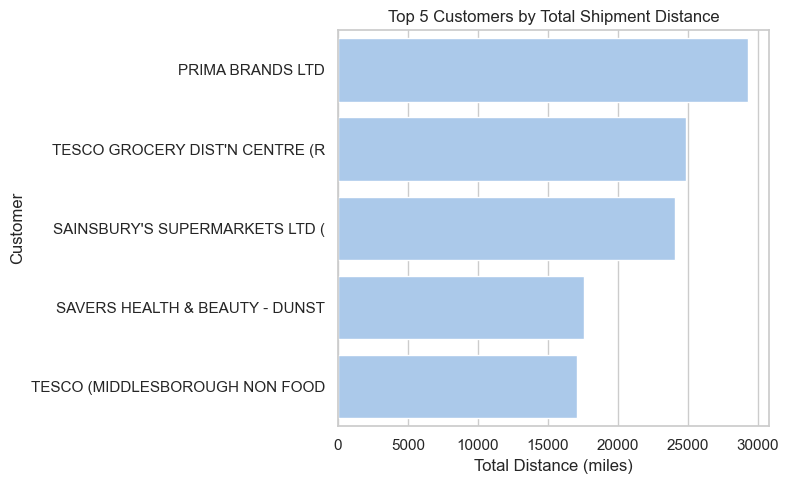

In [33]:
response = BIAgent.generate_response(question="What's the average distance of shipment for top 5 largest customers?")

In [34]:
print(response['answer'])

The average distance of shipment for the top 5 largest customers is 22601.6 miles.


In [35]:
# display_saved_plot(response['figure'])

In [36]:
from cost_optimization import (
 get_parameters_values, consolidate_shipments, calculate_metrics,
    analyze_consolidation_distribution, get_filtered_data
)

ModuleNotFoundError: No module named 'cost_optimization'

In [ ]:
from typing import Dict, Any

In [ ]:
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def execute_plot_code(plot_code: str,df) -> list:
    """
    Executes the provided plotting code. It searches for every occurrence of plt.show() in the code and
    replaces it with a plt.savefig() call that saves the current figure to a unique file.
    If no plt.show() is present and no plt.savefig() exists, it appends a plt.savefig() call at the end.
    
    Args:
        plot_code (str): The code to generate one or more plots.
    
    Returns:
        list: A list of file paths where the plots were saved.
    """
    plot_paths = []
    
    # Function to replace each plt.show() with a unique plt.savefig() call
    def replace_show(match):
        new_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")
        plot_paths.append(new_path)
        # Ensure proper indentation is preserved (using the match group 1)
        indent = match.group(1) if match.lastindex and match.group(1) else ""
        return f"{indent}plt.savefig('{new_path}', bbox_inches='tight')"
    
    # Replace all occurrences of plt.show() with unique plt.savefig() calls
    sanitized_code = re.sub(r'(^\s*)plt\.show\(\)', replace_show, plot_code, flags=re.MULTILINE)
    
    # If no plt.show was found and no plt.savefig exists in the code, append one at the end
    if not re.search(r"plt\.savefig", sanitized_code):
        new_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")
        sanitized_code += f"\nplt.savefig('{new_path}', bbox_inches='tight')"
        plot_paths.append(new_path)
    
#     print("Sanitized Code:\n", sanitized_code)
    
    exec_globals = {"df": df, "sns": sns, "plt": plt}
    try:
        exec(sanitized_code, exec_globals)
        plt.close('all')
    except Exception as e:
        return [f"Error generating plot: {e}"]
    
    return plot_paths

def display_saved_plot(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display.
    
    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

def extract_plot_code(intermediate_steps: list) -> tuple:
    """
    Extracts the plotting code from the agent's intermediate steps.
    
    Args:
        intermediate_steps (list): Intermediate steps from the agent response.
    
    Returns:
        tuple: (plot_code, response, thought)
    """
    for step in intermediate_steps:
        artifacts, _ = step
        
        # The agent's intermediate steps may contain the code under a key like 'tool_input'
        tool_input_ = artifacts.tool_input
        agent_message = artifacts.log
        
        # Extract plot code (everything after "```python" and before "```")
        match = re.search(r"```python(.*?)```", tool_input_, re.DOTALL)
        plot_code = match.group(1).strip() if match else None
        
        # Extract message (everything before "Thought:")
        response_match = re.search(r'^(.*?)\s*Thought:', agent_message, re.DOTALL)
        response = response_match.group(1).strip() if response_match else agent_message.strip()
        
        # Extract thought (text between "Thought:" and "Action:")
        thought_match = re.search(r'Thought:\s*(.*?)\s*Action:', agent_message, re.DOTALL)
        thought = thought_match.group(1).strip() if thought_match else ""
        
    return plot_code, response, thought

def agent_wrapper(agent_response: dict,df) -> dict:
    """
    Wraps the agent response to extract, execute, and display plotting code for each intermediate step.
    For each step, any generated plots are saved using unique file names.
    
    The final output is constructed to show:
      - Step 1 message
      - Step 1 plot paths
      - Step 2 message
      - Step 2 plot paths
      - ...
      - Final agent response
    
    Args:
        agent_response (dict): Response from the agent.
    
    Returns:
        dict: Contains the agent input, a list of step outputs (each with a message and plot paths),
              and a final_answer string combining all.
    """
    intermediate_steps = agent_response.get("intermediate_steps", [])
    step_outputs = []
    
    for step in intermediate_steps:
        artifacts, _ = step
        tool_input_ = artifacts.tool_input
        agent_log = artifacts.log
        
        # Extract the plotting code from the tool_input
        match = re.search(r"```python(.*?)```", tool_input_, re.DOTALL)
        plot_code = match.group(1).strip() if match else None
        plot_code = plot_code if "plt.show" in plot_code else None
        
        # Extract the message (everything before "Thought:") and optional thought
        message_match = re.search(r'^(.*?)\s*Thought:', agent_log, re.DOTALL)
        message = message_match.group(1).strip() if message_match else agent_log.strip()
        thought_match = re.search(r'Thought:\s*(.*?)\s*Action:', agent_log, re.DOTALL)
        thought = thought_match.group(1).strip() if thought_match else ""
        full_message = message + ("\n" + thought if thought else "")
        
        # Execute the plotting code and get a list of plot paths
        plot_paths = execute_plot_code(plot_code,df) if plot_code else []
        
        step_outputs.append({
            "message": full_message,
            "plot_paths": plot_paths
        })
    
    # Build the final answer by interleaving messages and the list of plot paths
    final_message = ""
    for idx, step in enumerate(step_outputs, 1):
        final_message += f"Step {idx} Message:\n{step['message']}\n"
        if step['plot_paths']:
            for i, path in enumerate(step['plot_paths'], 1):
                final_message += f"Step {idx} Plot {i}: {path}\n"
        else:
            final_message += f"Step {idx} Plot: No plot generated.\n"
    
    final_agent_response = agent_response.get("output", "")
#     final_message += "\nFinal Agent Response:\n" + final_agent_response
    
    return {
        "input": agent_response.get("input"),
        "steps": step_outputs,
        "final_answer": final_agent_response
    }


In [ ]:
class AgenticCostOptimizer:
    def __init__(self, llm, parameters):
        """
        Initialize the Agentic Cost Optimizer.

        :param llm: The LLM model to use for queries.
        :param parameters: Dictionary containing required parameters.
        """
        self.llm = llm
        self.parameters = parameters
        self.df = parameters.get("df", pd.DataFrame())
        self.shipment_window_range = (1, 10)
        self.total_shipment_capacity = 36

    def load_data(self):
        self.rate_card_ambient = pd.read_excel('Complete Input.xlsx', sheet_name='AMBIENT')
        self.rate_card_ambcontrol = pd.read_excel('Complete Input.xlsx', sheet_name='AMBCONTROL')
        return {"rate_card_ambient":self.rate_card_ambient,"rate_card_ambcontrol":self.rate_card_ambcontrol}
    
    def get_filtered_df_from_question(self):
        """Extracts filtered data based on user query parameters."""
        group_field = 'SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME'
        df = self.parameters['df']
        df['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'], dayfirst=True)
        
        df = get_filtered_data(self.parameters, df)
        if df.empty:
            raise ValueError("No data available for selected parameters. Try again!")
        return df
    
    def get_cost_saving_data(self):
        """Runs cost-saving algorithm and returns result DataFrame."""
        
        df = self.get_filtered_df_from_question()
        print("Shape of original data after filtering:",df.shape)
        
        df['GROUP'] = df['SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME']
        grouped = df.groupby(['PROD TYPE', 'GROUP'])
        date_range = pd.date_range(start=self.parameters['start_date'], end=self.parameters['end_date'])

        
        all_results = []
        rate_card = self.load_data()
        for shipment_window in range(self.shipment_window_range[0], self.shipment_window_range[1] + 1):
            print(f"Consolidating orders for shipment window: {shipment_window}")
            all_consolidated_shipments = []
            for _, group_df in grouped:
                consolidated_shipments, _ = consolidate_shipments(
                    group_df, 0, 95, shipment_window, date_range, lambda: None, self.total_shipment_capacity,rate_card
                )
                all_consolidated_shipments.extend(consolidated_shipments)
            
            metrics = calculate_metrics(all_consolidated_shipments, df)
            distribution, distribution_percentage = analyze_consolidation_distribution(all_consolidated_shipments, df)
            
            result = {
                'Shipment Window': shipment_window,
                'Total Orders': metrics['Total Orders'],
                'Total Shipments': metrics['Total Shipments'],
                'Total Shipment Cost': round(metrics['Total Shipment Cost'], 1),
                'Total Baseline Cost': round(metrics['Total Baseline Cost'], 1),
                'Cost Savings': metrics['Cost Savings'],
                'Percent Savings': round(metrics['Percent Savings'], 1),
                'Average Utilization': round(metrics['Average Utilization'], 1),
                'CO2 Emission': round(metrics['CO2 Emission'], 1)
            }
            all_results.append(result)
        
        self.parameters['all_results'] = pd.DataFrame(all_results)
    
    def consolidate_for_shipment_window(self):
        """Runs consolidation algorithm based on the selected shipment window."""
        df = self.get_filtered_df_from_question()
        df['GROUP'] = df['SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME']
        grouped = df.groupby(['PROD TYPE', 'GROUP'])
        date_range = pd.date_range(start=self.parameters['start_date'], end=self.parameters['end_date'])
        
        all_consolidated_shipments = []
        rate_card = self.load_data()
        for _, group_df in grouped:
            consolidated_shipments, _ = consolidate_shipments(
                group_df, 0, 95, self.parameters['window'], date_range, lambda: None, self.total_shipment_capacity,rate_card
            )
            all_consolidated_shipments.extend(consolidated_shipments)
        
        self.parameters['all_consolidated_shipments'] = pd.DataFrame(all_consolidated_shipments)
    
    def compare_before_and_after_consolidation(self):
        """Compares shipments before and after consolidation."""
        consolidated_df = self.parameters['all_consolidated_shipments']
        df = self.get_filtered_df_from_question()
        
        before = {
            "Days": df['SHIPPED_DATE'].nunique(),
            "Pallets Per Day": df['Total Pallets'].sum() / df['SHIPPED_DATE'].nunique(),
            "Pallets per Shipment": df['Total Pallets'].sum() / len(df)
        }
        after = {
            "Days": consolidated_df['Date'].nunique(),
            "Pallets Per Day": consolidated_df['Total Pallets'].sum() / consolidated_df['Date'].nunique(),
            "Pallets per Shipment": consolidated_df['Total Pallets'].sum() / len(consolidated_df)
        }
        
        percentage_change = {
            key: round(((after[key] - before[key]) / before[key]) * 100, 2) for key in before
        }
        
        comparison_df = pd.DataFrame({"Before": before, "After": after, "% Change": percentage_change})
#         print(comparison_df.to_dict())
        return comparison_df
    
    def handle_query(self, question):
            """Handles user queries dynamically, storing conversation history."""
            chat_history = []
            chat_history.append({"Human": question})

            result = get_parameters_values(self.parameters["api_key"], question)
            self.parameters.update(result)
            chat_history.append({"Agent": f"Parameters: {result}"})

            self.get_cost_saving_data()
            display(self.parameters['all_results'])
            max_savings_row = self.parameters['all_results'].loc[self.parameters['all_results']['Cost Savings'].idxmax()].to_dict()
            chat_history.append({"Agent": f"Optimum results: {max_savings_row}"})
            
            agent = create_pandas_dataframe_agent(self.llm, self.parameters['all_results'], verbose=False, 
                                                  allow_dangerous_code=True, handle_parsing_errors=True,
                                                 return_intermediate_steps=True)
            while True:
                display(HTML("""
                    <div style="background-color: yellow; padding: 10px; border-radius: 5px; 
                                font-size: 16px; border: 1px solid black; width: fit-content;">
                        <strong>Ask follow-up question or press Enter to proceed:</strong>
                    </div>
                """))
                user_input = input()
                if not user_input:
                    break
                else:
                    try:
                        response = agent.invoke(user_input)

#                         step = response.get("intermediate_steps")[0] # Since, there is only one step
#                         artifacts,output = step
#                         print("Log:\n",artifacts.log)
                        
                        response_ = agent_wrapper(response,self.parameters['all_results'])
        
                        for i,step in enumerate(response_['steps']):
                            print(f"Step {i+1}")
                            print(step['message'])
                            for plot in step['plot_paths']:
                                display_saved_plot(plot)
                        print(response_["final_answer"])
                                


#                         if response_['plot_path']!='No plotting code found.':
#                             display_saved_plot(response_['plot_path'])
                            
                        chat_history.append({"Human": user_input})
                        chat_history.append({"Agent": response_['final_answer']})
                        
#                         print("Agent Response:", response_['answer'])
                    except Exception as e:
                        print("Error processing follow-up question:",e)
                        print("Try reshaping your question.")
                        chat_history.append({"Human": user_input})
                        chat_history.append({"Agent": e})
                    
            user_window = input("Choose shipment window or press Enter to use default: ")
            self.parameters["window"] = int(user_window) if user_window else self.parameters['all_results']['Cost Savings'].idxmax()


            self.consolidate_for_shipment_window()
            display(self.parameters['all_consolidated_shipments'])

            agent = create_pandas_dataframe_agent(self.llm, self.parameters['all_consolidated_shipments'], verbose=False,
                                                  allow_dangerous_code=True,handle_parsing_errors=True,
                                                 return_intermediate_steps=True)
            while True:
                display(HTML("""
                    <div style="background-color: yellow; padding: 10px; border-radius: 5px; 
                                font-size: 16px; border: 1px solid black; width: fit-content;">
                        <strong>Ask follow-up question or press Enter to proceed:</strong>
                    </div>
                """))
                user_followup = input()
                if not user_followup:
                    break
                else:
                    try:
                        response = agent.invoke(user_followup)                        
                        response_ = agent_wrapper(response,self.parameters['all_consolidated_shipments'])
                        
                        for i,step in enumerate(response_['steps']):
                            print(f"Step {i+1}")
                            print(step['message'])
                            for plot in step['plot_paths']:
                                display_saved_plot(plot)
                        
                        print(response_["final_answer"])
                        
#                         if response_['plot_path']!='No plotting code found.':
#                             display_saved_plot(response_['plot_path'])
                            
                        chat_history.append({"Human": user_followup})
                        chat_history.append({"Agent": response_["final_answer"]})
                        
#                         print("Agent Response:", response_['answer'])
                        
                    except Exception as e:
                        print("Error processing follow-up question:", e)
                        print("Try rephrasing your question.")
                        chat_history.append({"Human": user_followup})
                        chat_history.append({"Agent": e})
            
            self.parameters['comparison'] = self.compare_before_and_after_consolidation()
            chat_history.append({"Agent": f"Before and After Consolidation comparison: {self.parameters['comparison'].to_dict()}"})

            return chat_history
    

In [ ]:
file_name = "Complete Input.xlsx"
cost_saving_input_df = pd.read_excel('Complete Input.xlsx', sheet_name='Sheet1')

In [ ]:
query = "How can I optimize the shipment costs for user ALLOGA UK in January?"

In [ ]:
parameters = {"api_key": openai.api_key, 
              "query": query, 
              "file_name":file_name,
              "df": cost_saving_input_df
             }

In [ ]:
cost_saving_input_df

In [ ]:
agent = AgenticCostOptimizer(llm, parameters)
conv = agent.handle_query(query)

In [ ]:
chat=[]
for msg in conv:
    key, value = list(msg.items())[0]
    if "Agent" in key:
        if type(value) is not str:
            value = str(value)
        chat.append(AIMessage(content=value))
    else:
        chat.append(HumanMessage(content=value))

In [ ]:
result = llm.invoke(f"Summarise this conversation and provide a formatted response to the first question asked by human. Hers is the conversation: {chat}")


In [ ]:
display(Markdown("**Question**: \n\n"+parameters["query"]+'\n\n'+"**Answer**: \n\n"+result.content))

----
## Building a Agentic Workflow using Langgraph

In [34]:
# Define the path to the module directory (only the folder, not the .py file)
module_dir = os.path.abspath("/Users/ay/Desktop/MultiAgent_Perrigo/Perrigo-Agentic_v7")
current_dir = os.getcwd()
os.chdir(module_dir)
print(f"Directory changed from current to {module_dir}")
# Add it to sys.path if not already present
# if module_dir not in sys.path:
#     sys.path.append(module_dir)


Directory changed from current to /Users/ay/Desktop/MultiAgent_Perrigo/Perrigo-Agentic_v7


In [35]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
import operator

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain.schema import HumanMessage


from src.agents.BIAgent_Node import BIAgent_Class, execute_analysis
from src.orchestrater.supervisor import supervisor_chain, members
from src.agents.CostOptimization_Node import AgenticCostOptimizer
from src.agents.Static_CostOptimization_Node import Static_CostOptimization_Class
from src.utils.openai_api import get_supervisor_llm
from src.utils.load_templates import load_template
# from src.core.order_consolidation.consolidation_ui import show_ui_cost_saving_agent, show_ui_cost_saving_agent_static


2025-04-13 03:51:12.246 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 03:51:12.247 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-04-13 03:51:12.268 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 03:51:12.283 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [36]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    next: str


In [37]:
# ---------------------- Generic Agent Node ----------------------
def agent_node(state, agent, name):
    """
    Generic agent node that calls the provided agent function with the state.
    """
    result = agent(state)
    return {"messages": result, "next": "supervisor"}

In [38]:
def display_saved_plot2(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display to prevent non-interactive warnings.

    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

In [39]:
def get_question(state, supervisor_chain):
    """
    Extract a single-line question from the conversation history to pass to an agent.
    """
    all_msg = []
    for msg in state['messages']:
        all_msg.append(msg.content)

    text = f"""Next agent to be called, use this conversation: {"\n".join(all_msg)} to create a single 
    line question to be passed next to this agent as a question. Keep track of these parameters while summarising:
        start_date;
        end_date;
        group_method;
        all_post_code; 
        all_customers;
        selected_postcodes; 
        selected_customers;
        scenario;
        shipment_window_range;
        total_shipment_capacity;
        utilization_threshold;
        .Provide your answer in `direct_response`."""
    response = supervisor_chain.invoke([HumanMessage(content=text)])
    print("Inside Get Question; Direct_response\n", response['direct_response'])
    return response

In [40]:
def supervisor_node(state: AgentState):
    """
    Supervisor Node: Uses the supervisor chain to determine the next agent.
    Also handles direct responses from the supervisor.
    """
    result = supervisor_chain.invoke(state['messages'])
    
    # Handle direct responses from the supervisor
    if result['next'] == 'SELF_RESPONSE':
        if 'direct_response' in result:
            return {"messages": [AIMessage(content=result['direct_response'])], "next": "FINISH"}
        else:
            # Fallback if direct_response field is somehow missing
            return {"messages": [AIMessage(content="I understand your question. Let me answer directly.")], "next": "FINISH"}
    
    # Original routing logic - use thought_process if available, otherwise use a generic message
    thought_process = result.get('thought_process', f"Calling {result['next']}...")
    return {"messages": [AIMessage(content=thought_process)], "next": result['next']}

In [41]:
# ---------------------- Insights Agent ----------------------

def bi_agent(state: AgentState):
    """
    Insights Agent is responsible for analyzing shipment data to generate insights. 
    It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, identifying trends, 
    comparing metrics across different dimensions (e.g., users, regions), and generating visualizations to help 
    understand shipment-related patterns and performance.
    """
    # Load dataset
    data_path = os.path.join("src", "data", "Outbound_Data.csv")
    df = pd.read_csv(data_path)
    
    # Load data description
    data_description = load_template("Outbound_data.txt")
    
    # Load BI Agent prompt
    bi_prompt = load_template("bi_agent_prompt.txt")
    
    # Define helper functions
    helper_functions = {"execute_analysis": execute_analysis}
    
    # Initialize BI Agent
    agent_instance = BIAgent_Class(
        llm=llm, 
        prompt=bi_prompt, 
        tools=[], 
        data_description=data_description, 
        dataset=df, 
        helper_functions=helper_functions
    )
    
    # Get question using the supervisor chain
    question = get_question(state,supervisor_chain)['direct_response']
    print(f"Question for Insights Agent:\n{question}")
    # Generate response
    response = agent_instance.generate_response(question)
    
    # # Store in session state
    # if 'bi_agent_responses' not in st.session_state:
    #     st.session_state.bi_agent_responses = []
    
    # bi_response = {
    #     'question': question,
    #     'answer': response['answer'],
    #     'figure': response['figure'],
    #     'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    # }
    
    # st.session_state.bi_agent_responses.append(bi_response)
    
    # Display figure if available
    # if response['figure']:
    #     # print("Figure Displayed")
    #     display_saved_plot2(response['figure'])
        # display_saved_plot(response['figure'])
    
    message = response['answer']
    
    return [HumanMessage(content=message)]


In [42]:
# ---------------------- Dynamic Cost Optimization Agent ----------------------

def Dynamic_CostOptimization_Agent(state: AgentState):
    """
    The Dynamic Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
    strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving 
    opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations 
    (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and comparisons
    between current and optimized operations. The agent also calculates key performance metrics like cost per 
    pallet, truck utilization rate, and cost savings over time. This agent is called when the user asks about 
    shipment cost reduction or optimization scenarios.
    """

    # Load data
    file_path = os.path.join("src", "data", "Complete Input.xlsx")
    df = pd.read_excel(file_path, sheet_name="Sheet1")
    
    # Get question using the supervisor chain
    question = get_question(state,supervisor_chain)['direct_response']
    print(f"Question for DCO-Agent:\n{question}")
    
    # Set up parameters
    parameters = {
        "api_key": os.getenv("OPENAI_API_KEY"),
        "query": question,
        "file_name": file_path,
        "df": df
    }
    
    # Initialize agent and handle query
    agent_instance = AgenticCostOptimizer(llm, parameters)
    response_parameters = agent_instance.handle_query(question)
    
    # # Display UI
    # show_ui_cost_saving_agent(response_parameters)
    
    # # Store in session state
    # if 'cost_optimization_response' not in st.session_state:
    #     st.session_state.cost_optimization_response = []
    
    consolidation_response = {
        'query': question,
        'answer': response_parameters['final_response'].content if hasattr(response_parameters['final_response'], 'content') else response_parameters['final_response'],
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # st.session_state.cost_optimization_response.append(consolidation_response)
    
    message = consolidation_response['answer']
    
    return [HumanMessage(content=message)]

In [43]:
# ---------------------- Static Cost Optimization Agent ----------------------

def Static_CostOptimization_agent(state: AgentState):
    """
    The Static Cost Optimization Agent is designed to analyze and optimize shipment costs by
    evaluating scenarios before and after consolidation. Using a Rate Card (which includes product type, short postcode, and cost per pallet),
    the agent calculates the base shipment costs. To maximize cost savings, the agent evaluates multiple delivery
    day scenarios (e.g., 5-day, 4-day, or 3-day delivery options).By applying consolidation day mappings, the agent
    aggregates shipments into fewer deliveries, reducing overall costs. The results include: Total shipment costs before and after consolidation ,
    Percentage savings achieved ,Key metrics such as the number of shipments and average pallets per shipment.
    This tool empowers users to identify the most cost-effective delivery strategies while maintaining operational efficiency.
    """

    # Load data
    file_path = os.path.join("src", "data", "Complete Input.xlsx")
    cost_saving_input_df = pd.read_excel(file_path, sheet_name="Sheet1")
    rate_card_path = os.path.join("src", "data", "Cost per pallet.xlsx")
    rate_card = pd.read_excel(rate_card_path)
    
    # Get question using the supervisor chain
    question = get_question(state,supervisor_chain)['direct_response']
    print(f"Question for SCO-Agent:\n{question}")
    
    # Set up parameters
    parameters = {
        "api_key": os.getenv("OPENAI_API_KEY"),
        "query": question,
        "complete_input": cost_saving_input_df,
        "rate_card": rate_card
    }
    
    # Initialize agent and handle query
    Static_agent = Static_CostOptimization_Class(llm, parameters)
    response_parameters = Static_agent.handle_query(question)
    
    # # Display UI
    # show_ui_cost_saving_agent_static(response_parameters)
    
    # # Store in session state
    # if 'static_optimization_response' not in st.session_state:
    #     st.session_state.static_optimization_response = []
    
    consolidation_response = {
        'query': question,
        'answer': response_parameters['final_response'].content if hasattr(response_parameters['final_response'], 'content') else response_parameters['final_response'],
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # st.session_state.static_optimization_response.append(consolidation_response)
    
    message = consolidation_response['answer']
    
    return [HumanMessage(content=message)]

In [44]:
# ---------------------- Generate Scenario Agent ----------------------

def generate_scenario_agent(state: AgentState):
    """
    Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios based on 
    user-defined parameters. This agent helps compare the outcomes of various decisions or actions, such as 
    the impact of increasing truck capacity, changing shipment consolidation strategies, or exploring different 
    operational scenarios. It can model changes in the system and assess the consequences of those changes to 
    support decision-making and optimization. This agent is called when the user asks about scenario generation,
    comparisons of different outcomes, or analysis of hypothetical situations.
    """

    # Load data
    file_path = os.path.join("src", "data", "Complete Input.xlsx")
    cost_saving_input_df = pd.read_excel(file_path, sheet_name="Sheet1")
    rate_card_path = os.path.join("src", "data", "Cost per pallet.xlsx")
    rate_card = pd.read_excel(rate_card_path)
    
    # Get question using the supervisor chain
    question = get_question(state,supervisor_chain)['direct_response']
    print(f"Question for GS-Agent:\n{question}")
    
    # Ask supervisor to determine which agent to use
    text = """You're inside `generate scenario agent` and your job is to generate a scenario using one of the following agents 
    `Dynamic` or `Static`. Based on the all the given info. Choose one to proceed."""
    
    state['messages'] = add_messages(state['messages'], [HumanMessage(content=text)])
    response = supervisor_chain.invoke(state['messages'])
    state['messages'] = add_messages(state['messages'], [HumanMessage(content=response.get('thought_process', ""))])
    
    message = ""
    
    if response['next'] == 'Dynamic Cost Optimization Agent':
        # Set up parameters
        parameters = {
            "api_key": os.getenv("OPENAI_API_KEY"),
            "query": question,
            "file_name": file_path,
            "df": cost_saving_input_df
        }
        
        # Initialize agent and handle query
        agent = AgenticCostOptimizer(llm, parameters)
        response_result = agent.handle_query(question)
        
        # # Display UI
        # show_ui_cost_saving_agent(response_result)
        
        # # Store in session state
        # if 'cost_optimization_response' not in st.session_state:
        #     st.session_state.cost_optimization_response = []
        
        consolidation_response = {
            'query': question,
            'answer': response_result['final_response'].content if hasattr(response_result['final_response'], 'content') else response_result['final_response'],
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # st.session_state.cost_optimization_response.append(consolidation_response)
        
        message = consolidation_response['answer']
        
    elif response['next'] == 'Static Cost Optimization Agent':
        # Set up parameters
        parameters = {
            "api_key": os.getenv("OPENAI_API_KEY"),
            "query": question,
            "complete_input": cost_saving_input_df,
            "rate_card": rate_card
        }
        
        # Initialize agent and handle query
        Static_agent = Static_CostOptimization_Class(llm, parameters)
        response_result = Static_agent.handle_query(question)
        
        # Display UI
        # show_ui_cost_saving_agent_static(response_result)
        
        # # Store in session state
        # if 'static_optimization_response' not in st.session_state:
        #     st.session_state.static_optimization_response = []
        
        consolidation_response = {
            'query': question,
            'answer': response_result['final_response'].content if hasattr(response_result['final_response'], 'content') else response_result['final_response'],
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # st.session_state.static_optimization_response.append(consolidation_response)
        
        message = consolidation_response['answer']
        
    else:
        message = 'Generate Scenario Agent called but no matching scenario type was found.'
    
    return [HumanMessage(content=message)]



In [45]:
# ---------------------- Workflow Setup ----------------------

# Define agent nodes
bi_agent_node = functools.partial(agent_node, agent=bi_agent, name="Insights Agent")
dynamic_cost_optimization_node = functools.partial(agent_node, agent=Dynamic_CostOptimization_Agent, name="Dynamic Cost Optimization Agent")
static_cost_optimization_node = functools.partial(agent_node, agent=Static_CostOptimization_agent, name="Static Cost Optimization Agent")
generate_scenario_agent_node = functools.partial(agent_node, agent=generate_scenario_agent, name="Generate Scenario Agent")


In [46]:
# Define the multi-agent workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("Insights Agent", bi_agent_node)
workflow.add_node("Dynamic Cost Optimization Agent", dynamic_cost_optimization_node)
workflow.add_node("Static Cost Optimization Agent", static_cost_optimization_node)
workflow.add_node("Generate Scenario Agent", generate_scenario_agent_node)
workflow.add_node("supervisor", supervisor_node)



# Add edges from agents to supervisor
for member in members:
    if member['agent_name'] != "SELF_RESPONSE":  # Skip self_response as it's not a real node
        workflow.add_edge(member['agent_name'], "supervisor")

# Define conditional routing
conditional_map = {k['agent_name']: k['agent_name'] for k in members if k['agent_name'] != "SELF_RESPONSE"}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)


# Set entry point
workflow.set_entry_point("supervisor")

# Compile the workflow with the memory checkpointer
graph = workflow.compile(checkpointer=memory)

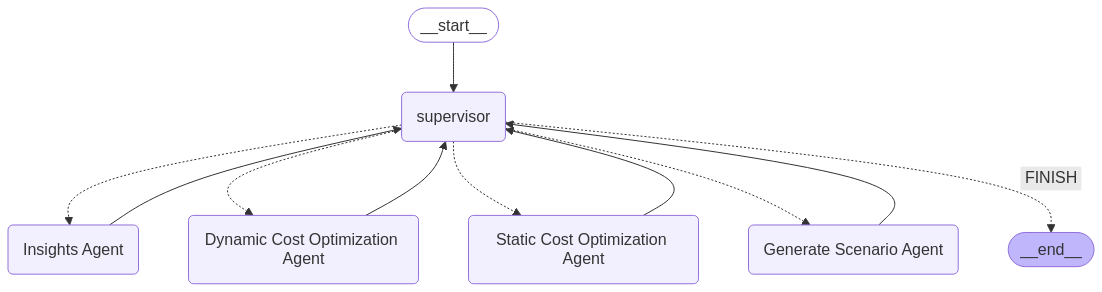

In [47]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

----

In [48]:
graph.nodes

{'__start__': <langgraph.pregel.read.PregelNode at 0x1434b8e60>,
 'Insights Agent': <langgraph.pregel.read.PregelNode at 0x1434b8b90>,
 'Dynamic Cost Optimization Agent': <langgraph.pregel.read.PregelNode at 0x1434b8c20>,
 'Static Cost Optimization Agent': <langgraph.pregel.read.PregelNode at 0x1434b8cb0>,
 'Generate Scenario Agent': <langgraph.pregel.read.PregelNode at 0x1434b8d40>,
 'supervisor': <langgraph.pregel.read.PregelNode at 0x1434b8ef0>}

-----

#### Checking the working of BI Agent

In [49]:
state = {"messages":[HumanMessage(content="Check if the PRIMA BRANDS LTD consistently has high cost than others.")],"next":"supervisor"}

In [50]:
current_state= graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='The user is asking for a comparison of shipment costs for PRIMA BRANDS LTD against other entities. This requires analyzing shipment data to identify trends and compare metrics across different dimensions, such as cost. The Insights Agent is best suited for this task as it can perform exploratory data analysis and generate insights on shipment-related patterns and performance.', additional_kwargs={}, response_metadata={})],
 'next': 'Insights Agent'}

In [51]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content='Check if the PRIMA BRANDS LTD consistently has high cost than others.', additional_kwargs={}, response_metadata={}, id='ef760558-ab0c-401d-b16c-7a4d4aa19576'),
  AIMessage(content='The user is asking for a comparison of shipment costs for PRIMA BRANDS LTD against other entities. This requires analyzing shipment data to identify trends and compare metrics across different dimensions, such as cost. The Insights Agent is best suited for this task as it can perform exploratory data analysis and generate insights on shipment-related patterns and performance.', additional_kwargs={}, response_metadata={}, id='76f63b8c-301c-42d8-b889-e37387e1541e')],
 'next': 'Insights Agent'}

2025-04-13 03:51:43.508 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 03:51:43.708 
  command:

    streamlit run /Users/ay/Desktop/GenAI-POC/GenAI_11/lib/python3.13/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-13 03:51:43.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 "Compare the shipment costs for PRIMA BRANDS LTD against other entities from [start_date] to [end_date], using [group_method] and considering all postcodes and customers. Focus on selected postcodes: [selected_postcodes] and selected customers: [selected_customers]. Analyze the scenario with a shipment window range of [shipment_window_range], total shipment capacity of [total_shipment_capacity], and a utilization threshold of [utilization_threshold]."
Question for Insights Agent:
"Compare the shipment costs for PRIMA BRANDS LTD against other entities from [start_date] to [end_date], using [group_method] and considering all postcodes and customers. Focus on selected postcodes: [selected_postcodes] and selected customers: [selected_customers]. Analyze the scenario with a shipment window range of [shipment_window_range], total shipment capacity of [total_shipment_capacity], and a utilization threshold of [utilization_threshold]."
Extracting parameters

2025-04-13 03:51:53.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 03:51:53.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


['PRIMA BRANDS LTD']
[]
start_date : 2023-01-01
end_date : 2025-02-25
group_method : Customer Level
all_post_code : None
all_customers : False
selected_postcodes : []
selected_customers : ['PRIMA BRANDS LTD']
scenario : None
shipment_window_range : [1, 10]
total_shipment_capacity : 36
utilization_threshold : 95


{'messages': [HumanMessage(content="The total shipment cost for PRIMA BRANDS LTD is £132161.1. Compared to other entities, PRIMA BRANDS LTD's shipment costs are highlighted in red in the chart. The analysis was conducted for the period from 2023-01-01 to 2025-02-25, focusing on the customer level, considering all postcodes and customers, with a shipment window range of 1 to 10, a total shipment capacity of 36, and a utilization threshold of 95%.", additional_kwargs={}, response_metadata={})],
 'next': 'supervisor'}

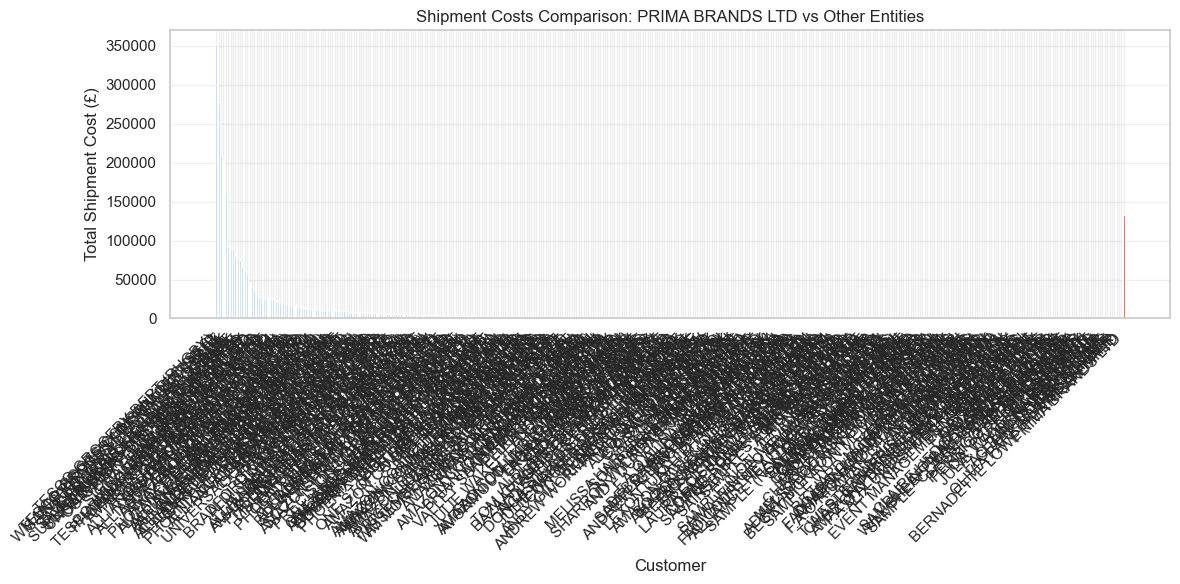

In [52]:
current_state = graph.nodes['Insights Agent'].invoke(state)
current_state

In [56]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content="What's the average distance of shipment for top 5 largest customers?", additional_kwargs={}, response_metadata={}, id='3a71f323-05f5-48fb-afd3-584a8c0a3fcd'),
  AIMessage(content='The user is asking for an analysis of shipment data to determine the average distance for the top 5 largest customers. This requires identifying the top customers based on shipment volume or value and then calculating the average distance for their shipments. This task involves data analysis and insights generation, which falls under the responsibilities of the Insights Agent.', additional_kwargs={}, response_metadata={}, id='97adc3df-4758-4ff9-a523-82d0abc50a02'),
  HumanMessage(content="The average shipment distance for the top 5 largest customers based on shipment value is 113.7 km. The parameters used for filtering the data include a date range from '2023-01-01' to '2025-02-25', and the analysis was conducted at the customer level without any specific postcode or custom

In [57]:
current_state = graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='The user has provided the average shipment distance for the top 5 largest customers based on shipment value, along with the parameters used for filtering the data. Since the user has already received the information they were looking for, no further action is required.', additional_kwargs={}, response_metadata={})],
 'next': 'FINISH'}

In [58]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content="What's the average distance of shipment for top 5 largest customers?", additional_kwargs={}, response_metadata={}, id='3a71f323-05f5-48fb-afd3-584a8c0a3fcd'),
  AIMessage(content='The user is asking for an analysis of shipment data to determine the average distance for the top 5 largest customers. This requires identifying the top customers based on shipment volume or value and then calculating the average distance for their shipments. This task involves data analysis and insights generation, which falls under the responsibilities of the Insights Agent.', additional_kwargs={}, response_metadata={}, id='97adc3df-4758-4ff9-a523-82d0abc50a02'),
  HumanMessage(content="The average shipment distance for the top 5 largest customers based on shipment value is 113.7 km. The parameters used for filtering the data include a date range from '2023-01-01' to '2025-02-25', and the analysis was conducted at the customer level without any specific postcode or custom

In [59]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

'EXIT'

In [60]:
state = {"messages":[HumanMessage(content="How can I optimize the shipment costs for user ALLOGA UK in January?")],"next":"supervisor"}

In [61]:
current_state= graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='The user is asking about optimizing shipment costs for a specific user (ALLOGA UK) in January. This requires analyzing shipment cost-related data and recommending strategies to reduce or optimize costs. Both dynamic and static cost optimization approaches should be considered to provide a comprehensive solution. Therefore, I will route this to both the Dynamic Cost Optimization Agent and the Static Cost Optimization Agent to get insights from both perspectives.', additional_kwargs={}, response_metadata={})],
 'next': 'Dynamic Cost Optimization Agent'}

In [62]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content='How can I optimize the shipment costs for user ALLOGA UK in January?', additional_kwargs={}, response_metadata={}, id='95112ad4-a93a-4137-97fc-94ac396858d5'),
  AIMessage(content='The user is asking about optimizing shipment costs for a specific user (ALLOGA UK) in January. This requires analyzing shipment cost-related data and recommending strategies to reduce or optimize costs. Both dynamic and static cost optimization approaches should be considered to provide a comprehensive solution. Therefore, I will route this to both the Dynamic Cost Optimization Agent and the Static Cost Optimization Agent to get insights from both perspectives.', additional_kwargs={}, response_metadata={}, id='c6a75301-52b9-4a76-84fe-f51a5b836ac0')],
 'next': 'Dynamic Cost Optimization Agent'}

In [63]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

2025-04-13 00:48:12.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:48:12.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 Optimize shipment costs for ALLOGA UK in January using both dynamic and static cost optimization approaches, considering parameters like start_date, end_date, group_method, all_post_code, all_customers, selected_postcodes, selected_customers, scenario, shipment_window_range, total_shipment_capacity, and utilization_threshold.
Question for DCO-Agent:
Optimize shipment costs for ALLOGA UK in January using both dynamic and static cost optimization approaches, considering parameters like start_date, end_date, group_method, all_post_code, all_customers, selected_postcodes, selected_customers, scenario, shipment_window_range, total_shipment_capacity, and utilization_threshold.


2025-04-13 00:48:20.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:48:20.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:48:20.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:48:20.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[]
[]
Extracted Parameters:

start_date 2024-01-01
end_date 2024-01-31
group_method Customer Level
all_post_code None
all_customers False
selected_postcodes []
selected_customers []
scenario None
shipment_window_range [1, 10]
total_shipment_capacity 36
utilization_threshold 95


ValueError: No data available for selected parameters. Try again!

In [ ]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

In [ ]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

In [ ]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

In [ ]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

-----
## Example 1: Finishing when answer is completed

In [64]:
question = "What's the average distance of shipment for top 5 largest customers?"
state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

================================ Human Message =================================

What's the average distance of shipment for top 5 largest customers?
================================== Ai Message ==================================

The user is asking for an analysis of shipment data to determine the average distance of shipments for the top 5 largest customers. This requires data analysis to identify the top customers and calculate the average shipment distance for them. The Insights Agent is best suited for this task as it handles exploratory data analysis and summary statistics.


2025-04-13 00:48:52.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:48:52.903 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 What is the average shipment distance for the top 5 largest customers?
Question for Insights Agent:
What is the average shipment distance for the top 5 largest customers?
Extracting parameters from question...


2025-04-13 00:49:00.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:00.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[]
[]
start_date : 2023-01-01
end_date : 2025-02-25
group_method : Customer Level
all_post_code : None
all_customers : True
selected_postcodes : []
selected_customers : []
scenario : None
shipment_window_range : [1, 10]
total_shipment_capacity : 36
utilization_threshold : 95
================================ Human Message =================================

The average shipment distance for the top 5 largest customers is as follows:                          Customer  Distance
0                       ALLOGA UK      12.2
1                            ASDA      93.7
2         BOOTS COMPANY PLC (SSC)      29.8
3      TESCO GROCERY DEPT (RUGBY)     107.4
4  WM MORRISONS SUPERMARKET LIMIT     133.2.
Parameters used: Date range from 2023-01-01 to 2025-02-25, all customers included, no specific postcodes or scenarios applied, shipment window range of 1 to 10, total shipment capacity of 36, and utilization threshold of 95%.
================================== Ai Message ============================

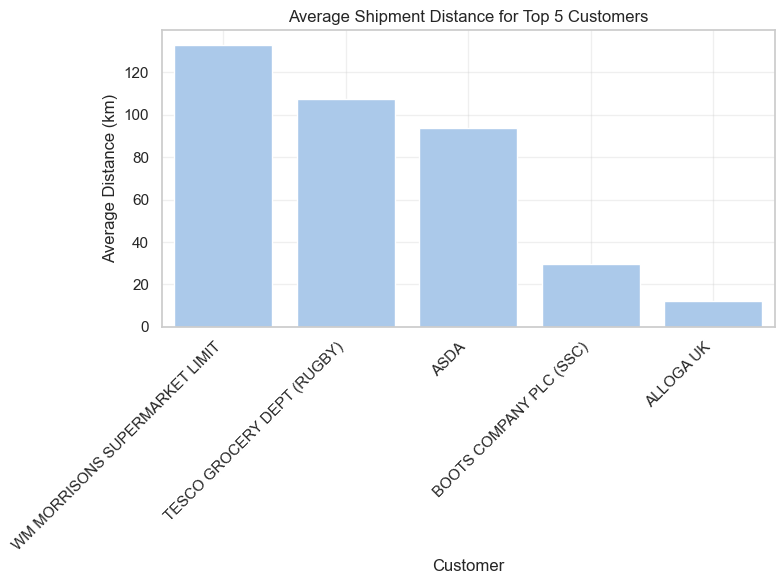

In [65]:
state['messages'][0].pretty_print()
counter=0
while state['next']!='FINISH' and counter<100:
    
    #Getting the current state
    current_state= graph.nodes[state['next']].invoke(state)
    current_state['messages'][0].pretty_print()

    # Updating the state
    state['messages']=add_messages(state['messages'],current_state['messages'])
    state['next'] = current_state['next']
    counter+=1


-----
## Example 2: Routing to different Agent

In [66]:
question = "Identify the customer for which shipment cost is highest and then help me to save the shipment cost for it."

In [67]:
# question = "How can I optimise my spends for top 5 postal codes in terms of spend"

In [68]:
config= {"configurable":{"thread_id":"1"}}

In [69]:
state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

================================ Human Message =================================

Identify the customer for which shipment cost is highest and then help me to save the shipment cost for it.
================================== Ai Message ==================================

The user's request involves two parts: identifying the customer with the highest shipment cost and then optimizing the shipment cost for that customer. The first part requires analyzing shipment data to find the customer with the highest cost, which is a task for the Insights Agent. Once the customer is identified, the next step is to optimize the shipment cost, which involves both Dynamic and Static Cost Optimization Agents to provide a comprehensive solution.


2025-04-13 00:49:17.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:17.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 "Identify the customer with the highest shipment cost using the shipment data from start_date to end_date, considering all customers and postcodes."
Question for Insights Agent:
"Identify the customer with the highest shipment cost using the shipment data from start_date to end_date, considering all customers and postcodes."
Extracting parameters from question...


2025-04-13 00:49:25.817 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:25.818 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[]
[]
start_date : 2023-01-01
end_date : 2025-02-25
group_method : Customer Level
all_post_code : True
all_customers : True
selected_postcodes : []
selected_customers : []
scenario : None
shipment_window_range : [1, 10]
total_shipment_capacity : 36
utilization_threshold : 95
================================ Human Message =================================

The customer with the highest shipment cost from 2023-01-01 to 2025-02-25 is TESCO GROCERY DEPT (RUGBY) with a total cost of £351901.4. The analysis considered all customers and postcodes within the specified date range.
================================== Ai Message ==================================

The user has identified the customer with the highest shipment cost as TESCO GROCERY DEPT (RUGBY) with a total cost of £351901.4. The next step is to optimize the shipment cost for this customer. To provide a comprehensive optimization solution, I will route the request to both the Dynamic Cost Optimization Agent and the Static Cost Opti

2025-04-13 00:49:45.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:45.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 Optimize the shipment cost for TESCO GROCERY DEPT (RUGBY) from 2023-01-01 to 2025-02-25, considering all postcodes and customers, with a focus on cost-saving strategies and comparing results from both Dynamic and Static Cost Optimization methods.
Question for DCO-Agent:
Optimize the shipment cost for TESCO GROCERY DEPT (RUGBY) from 2023-01-01 to 2025-02-25, considering all postcodes and customers, with a focus on cost-saving strategies and comparing results from both Dynamic and Static Cost Optimization methods.


2025-04-13 00:49:53.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:53.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:53.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:53.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:53.498 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:53.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


['TESCO GROCERY DEPT (RUGBY)']
[]
Extracted Parameters:

start_date 2023-01-01
end_date 2025-02-25
group_method Customer Level
all_post_code True
all_customers True
selected_postcodes []
selected_customers ['TESCO GROCERY DEPT (RUGBY)']
scenario None
shipment_window_range [1, 10]
total_shipment_capacity 36
utilization_threshold 95


2025-04-13 00:49:57.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:49:57.109 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:51:32.776 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:51:32.776 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:53:07.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:53:07.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:54:42.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 00:54:42.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Reponse END from Dynamic Agent
================================ Human Message =================================


        **Response from the Dynamic Cost Optimization Agent:**

We have successfully optimized the shipment cost for TESCO GROCERY DEPT (RUGBY) for the period from January 1, 2023, to February 25, 2025. Below are the optimum results and comparison insights derived from the analysis.

### Optimum Results:
- **Shipment Window:** 10.0 days
- **Total Orders:** 19,827
- **Total Shipments:** 6,893
- **Total Shipment Cost:** £2,644,950.60
- **Total Baseline Cost:** £3,173,405.30
- **Cost Savings:** £528,454.70
- **Percent Savings:** 16.7%
- **Average Utilization:** 40.5%
- **CO2 Emission:** 2,927,294.3 kg

### Comparison Results:
- **Days:** The shipment duration decreased by 0.92%, from 651 days to 645 days.
- **Pallets Per Day:** Increased by 0.93%, from approximately 154.53 pallets to 155.97 pallets.
- **Pallets per Shipment:** Showed a significant increase of 187.64%, from app

2025-04-13 01:10:00.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:10:00.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Inside Get Question; Direct_response
 Please optimize the shipment cost for TESCO GROCERY DEPT (RUGBY) using the Static Cost Optimization method for the period from January 1, 2023, to February 25, 2025. Consider all postcodes and customers, with a shipment window range of 1 to 10 days, total shipment capacity of 36, and a utilization threshold of 95%.
Question for SCO-Agent:
Please optimize the shipment cost for TESCO GROCERY DEPT (RUGBY) using the Static Cost Optimization method for the period from January 1, 2023, to February 25, 2025. Consider all postcodes and customers, with a shipment window range of 1 to 10 days, total shipment capacity of 36, and a utilization threshold of 95%.


2025-04-13 01:10:08.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:10:08.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:10:08.688 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:10:08.688 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[]
[]
Extracted Parameters:

start_date 2023-01-01
end_date 2025-02-25
group_method Customer Level
all_post_code True
all_customers True
selected_postcodes []
selected_customers []
scenario None
shipment_window_range [1, 10]
total_shipment_capacity 36
utilization_threshold 95


2025-04-13 01:10:40.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:10:40.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:13:32.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:13:32.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:16:46.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:16:46.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:19:38.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 01:19:38.875 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Reponse END from Static Agent
================================ Human Message =================================


        **Response from the Static Cost Optimization Agent:**

The optimization process for the shipment cost of TESCO GROCERY DEPT (RUGBY) has been successfully completed. Below are the results highlighting the best scenario for cost savings:

**Best Scenario for Cost Savings:**
- **Delivery Days:** 1 day delivery scenario
- **Scenario:** Only_Wed
- **Total Consolidated Cost:** £2,452,347.91
- **Number of Shipments:** 5,611
- **Average Pallets per Shipment:** 17.93

**Extracted Parameters:**
The parameters used for this optimization include: start date (January 1, 2023), end date (February 25, 2025), group method (Customer Level), all postcodes (True), all customers (True), shipment window range (1 to 10 days), total shipment capacity (36), and utilization threshold (95%).

If you have any further questions or require additional insights, please feel free to ask.  
        

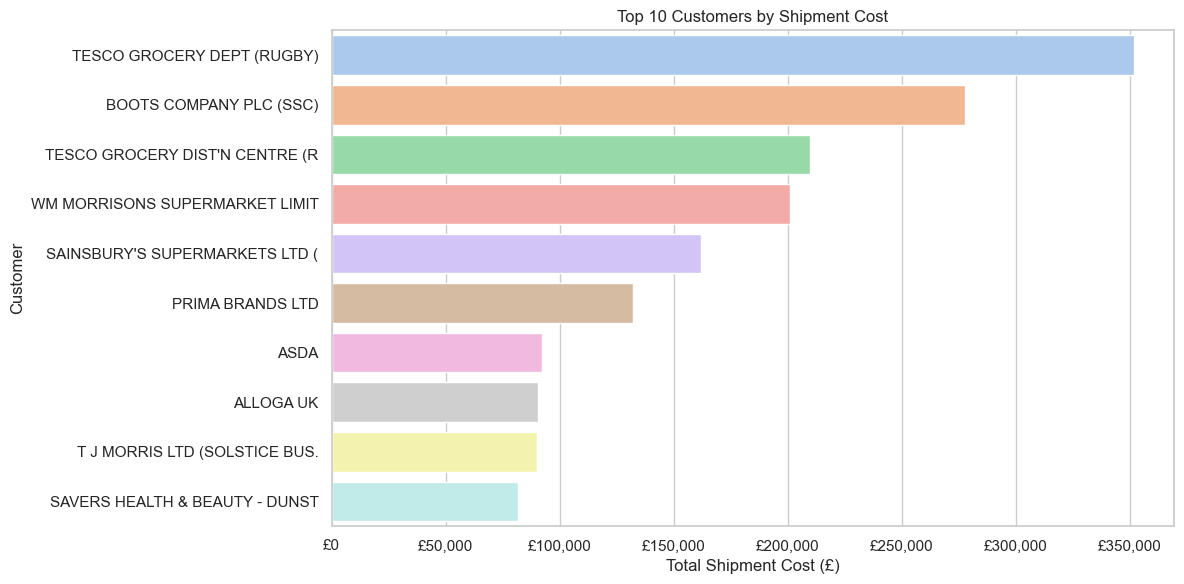

In [70]:
state['messages'][0].pretty_print()
counter=0
while state['next']!='FINISH' and counter<100:
    #Getting the current state
    current_state= graph.nodes[state['next']].invoke(state,config)
    current_state['messages'][0].pretty_print()
#     chat_msg.append(current_state['messages'][0])
    

    # Updating the state
    state['messages']=add_messages(state['messages'],current_state['messages'])
    state['next'] = current_state['next']
    counter+=1
#     state

In [71]:
state

{'messages': [HumanMessage(content='Identify the customer for which shipment cost is highest and then help me to save the shipment cost for it.', additional_kwargs={}, response_metadata={}, id='403e849e-e397-469a-be81-515e1a9942c5'),
  AIMessage(content="The user's request involves two parts: identifying the customer with the highest shipment cost and then optimizing the shipment cost for that customer. The first part requires analyzing shipment data to find the customer with the highest cost, which is a task for the Insights Agent. Once the customer is identified, the next step is to optimize the shipment cost, which involves both Dynamic and Static Cost Optimization Agents to provide a comprehensive solution.", additional_kwargs={}, response_metadata={}, id='e61bd60d-9445-4457-9778-8e23fae1d9b1'),
  HumanMessage(content='The customer with the highest shipment cost from 2023-01-01 to 2025-02-25 is TESCO GROCERY DEPT (RUGBY) with a total cost of £351901.4. The analysis considered all c

-----
## Example 3: Interrupting the workflow and taking input from user

In [ ]:
# counter=0
# while True:
#     question = input("Ask your question or Press Enter to Exit:\n")
#     if not question:
#         break
#     else:
        
#         state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}
#         while state['next']!='FINISH' and counter<100:

#             #Getting the current state
#             current_state= graph.nodes[state['next']].invoke(state)
#             current_state['messages'][0].pretty_print()

#             # Updating the state
#             state['messages']=add_messages(state['messages'],current_state['messages'])
#             state['next'] = current_state['next']
#             counter+=1


----The End---

-----